In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12.0, 6.0]

import okama as ok

*okama* has several methods to forecast portfolio perfomance:
- according to historical data (without distribution models)
- according to normal distribution
- according to lognormal distribution

### Testing distribution

Before we use normal or lognormal distribution models, we should test the portfolio returns historical distribution and see if it fits.  
There is a notebook dedicated to backtesting distributions.

In [2]:
ls = ['GLD.US', 'SPY.US', 'VNQ.US', 'AGG.US']
al = ok.AssetList(ls, inflation=False)
al

symbols          [GLD.US, SPY.US, VNQ.US, AGG.US]
currency                                      USD
first date                                2004-12
last_date                                 2021-03
period length                  16 years, 4 months
inflation                                    None
dtype: object

In [3]:
al.names

{'GLD.US': 'SPDR Gold Shares',
 'SPY.US': 'SPDR S&P 500 ETF Trust',
 'VNQ.US': 'Vanguard Real Estate Index Fund ETF Shares',
 'AGG.US': 'iShares Core U.S. Aggregate Bond ETF'}

In [4]:
al.kstest(distr='norm')

,GLD.US,SPY.US,VNQ.US,AGG.US
statistic,0.051107,0.099409,0.092534,0.052238
p-value,0.665934,0.038727,0.065363,0.639196


In [5]:
al.kstest(distr='lognorm')

,GLD.US,SPY.US,VNQ.US,AGG.US
statistic,0.048697,0.097847,0.094420,0.056042
p-value,0.722461,0.043760,0.056831,0.550384


We see that at least SPY is failed zero hypothesis  (didn't match 5% threshold) for both normal and lognormal distributions.  
But AGG has distribution close to normal. For GLD lognormal fits slightly better.  

Now we can construct the portfolio.

In [6]:
weights = [0.20, 0.10, 0.10, 0.60]
pf = ok.Portfolio(ls, ccy='USD', weights=weights, inflation=False)
pf

symbols          [GLD.US, SPY.US, VNQ.US, AGG.US]
weights                      [0.2, 0.1, 0.1, 0.6]
currency                                      USD
first date                                2004-12
last_date                                 2021-03
period length                  16 years, 4 months
dtype: object

In [7]:
pf.table

,asset name,ticker,weights
0,SPDR Gold Shares,GLD.US,0.2
1,SPDR S&P 500 ETF Trust,SPY.US,0.1
2,Vanguard Real Estate Index Fund ETF Shares,VNQ.US,0.1
3,iShares Core U.S. Aggregate Bond ETF,AGG.US,0.6


In [8]:
pf.kstest(distr='norm')

{'statistic': 0.057273967646867936, 'p-value': 0.5224432330880691}

In [9]:
pf.kstest(distr='lognorm')

{'statistic': 0.07537513561480304, 'p-value': 0.2048228544747267}

 As expected Kolmogorov-Smirnov test shows that normal distribution fits much better. AGG has 60% weight in the allocation.

### Forecasting

The most intuitive way to present forecasted portfolio performance is to use **plot_forecast** method to draw the accumulated return chart (historical return and forecasted data).  
It is possible to use arbitrary percentiles set (10, 50, 90 is a default attribute value).  

Maximum forecast period is limited with 1/2 historical data period. For example, if the historical data period is 10 years, it's possible to use forecast periods up to 5 years.

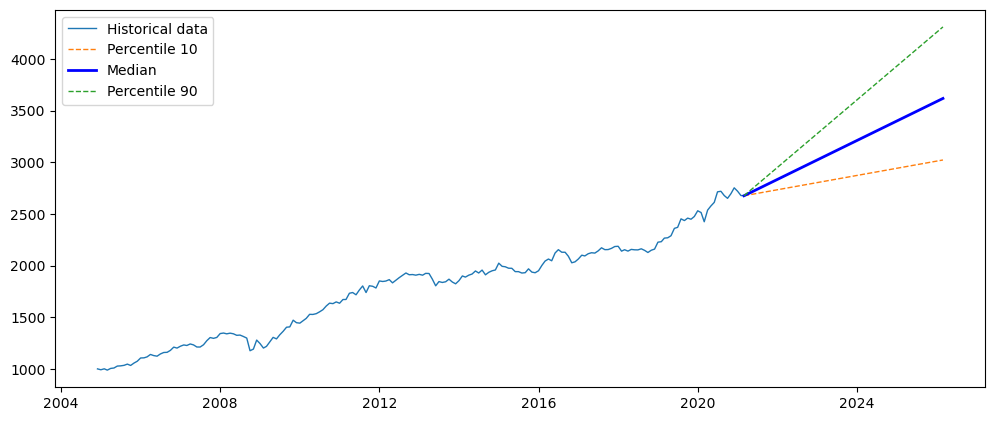

In [10]:
pf.plot_forecast(distr='norm', years=5, figsize=(12,5));

Another way to visualize the normally distributed random forecasted data is with Monte Carlo simulation ...

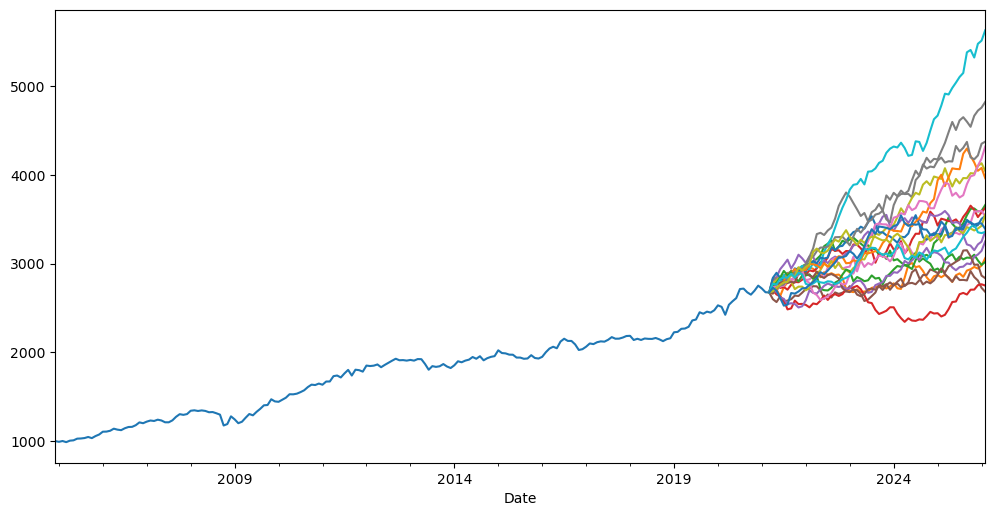

In [11]:
pf.plot_forecast_monte_carlo(distr='norm', years=5, n=20)  # Generates 20 forecasted wealth indexes (for random normally distributed returns time series)

We can get numeric CAGR percentiles for each period with **forecast_monte_carlo_cagr** method. To get credible forecast results high n values should be used.

In [12]:
pf.forecast_monte_carlo_cagr(distr='norm', years=5, percentiles=[1, 20, 50, 80, 99], n=10000)

{1: -0.006080272714871935,
 20: 0.03657770006085048,
 50: 0.06186946249029701,
 80: 0.0870825006157741,
 99: 0.13463865363213154}

The same could be used to get VAR (Value at Risk):

In [13]:
pf.forecast_monte_carlo_cagr(distr='norm', years=1, percentiles=[1], n=10000)  # 1% perecentile corresponds to 99% confidence level

{1: -0.08040379032418365}

One-year VAR (99% confidence level) is equal to 8%. It's a fair value for conservative portfolio.  
The probability of getting negative result in forecasted period is the percentile rank for zero CAGR value (score=0).

In [14]:
pf.percentile_inverse(distr='norm', years=1, score=0, n=10000) # one year period

16.73

### Lognormal distribution

Some financial assets returns have returns distribution close to lognormal.  
The same calculations could be repeated for lognormal distribution by setting dist='lognorm'.

In [15]:
ln = ok.Portfolio(['EDV.US'], inflation=False)
ln

symbols                    [EDV.US]
weights                       [1.0]
currency                        USD
first date                  2008-01
last_date                   2021-03
period length    13 years, 3 months
dtype: object

In [16]:
ln.names

{'EDV.US': 'Vanguard Extended Duration Treasury Index Fund ETF Shares'}

We can visualize the distribution and compare it with the lognormal PDF (Probability Distribution Function).

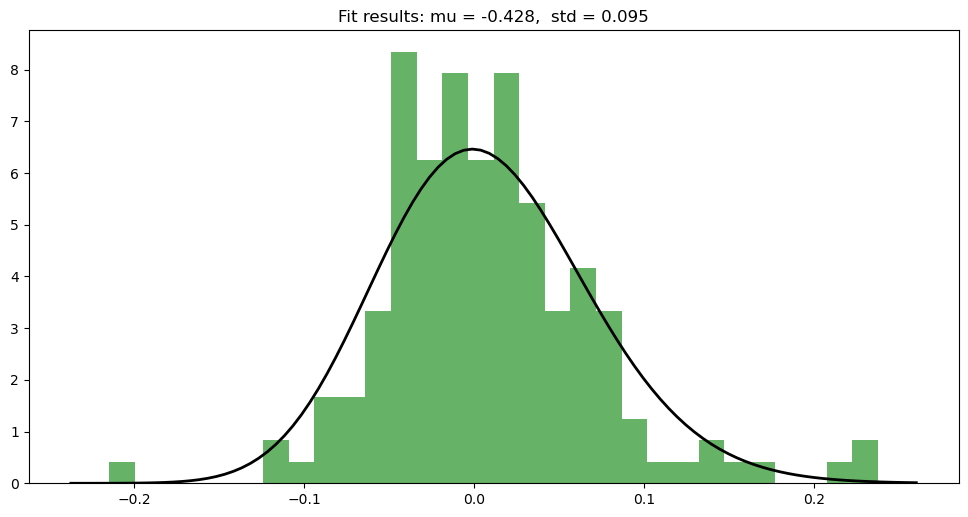

In [17]:
ln.plot_hist_fit(distr='lognorm', bins=30)

In [18]:
ln.kstest(distr='norm')  # Kolmogorov-Smirnov test for normal distribution

{'statistic': 0.07417264687293346, 'p-value': 0.32956293132900205}

In [19]:
ln.kstest(distr='lognorm')  # Kolmogorov-Smirnov test for lognormal distribution

{'statistic': 0.06600996018183855, 'p-value': 0.47257952766218236}

What is more important Kolmogorov-Smirnov test shows that historical distribution is slightly closer to lognormal.  
Therefore, we can use lognormal distribution to forecast.

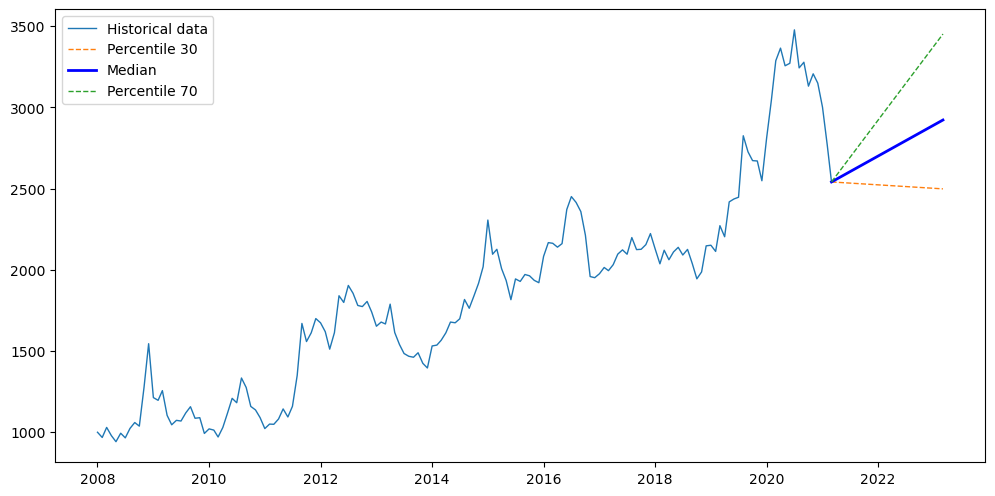

In [20]:
ln.plot_forecast(distr='lognorm', percentiles=[30, 50, 70], years=2, n=10000);

In [21]:
pf.forecast_monte_carlo_cagr(distr='lognorm', years=1, percentiles=[1, 20, 50, 80, 99], n=10000)

{1: -0.0870433220491049,
 20: 0.002258239205657776,
 50: 0.06141318579314048,
 80: 0.12378688808936283,
 99: 0.24852004581606094}

### Forecasting using historical data

If it's not possible to fit the data to normal or lognormal distributions, percentiles from the historical data could be used.

In [22]:
ht = ok.Portfolio(['SPY.US'])
ht

symbols                    [SPY.US]
weights                       [1.0]
currency                        USD
first date                  1993-02
last_date                   2021-02
period length    28 years, 1 months
dtype: object

In [23]:
ht.kstest('norm')

{'statistic': 0.07439883822741378, 'p-value': 0.04553010137140445}

In [24]:
ht.kstest('lognorm')

{'statistic': 0.0756298257021622, 'p-value': 0.04015897929171264}

Kolmogorov-Smirnov test is not passing 5% threshold...

Big deviation in the tails could be seen in Quantile-Quantile Plot.

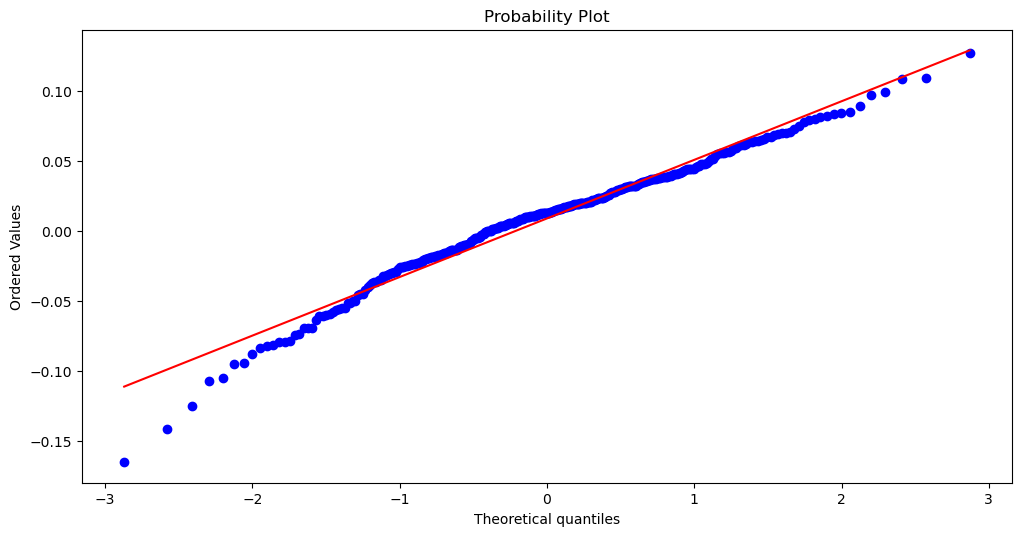

In [25]:
ht.plot_percentiles_fit('norm')

Then we can use percentiles from the historical data to forecast.

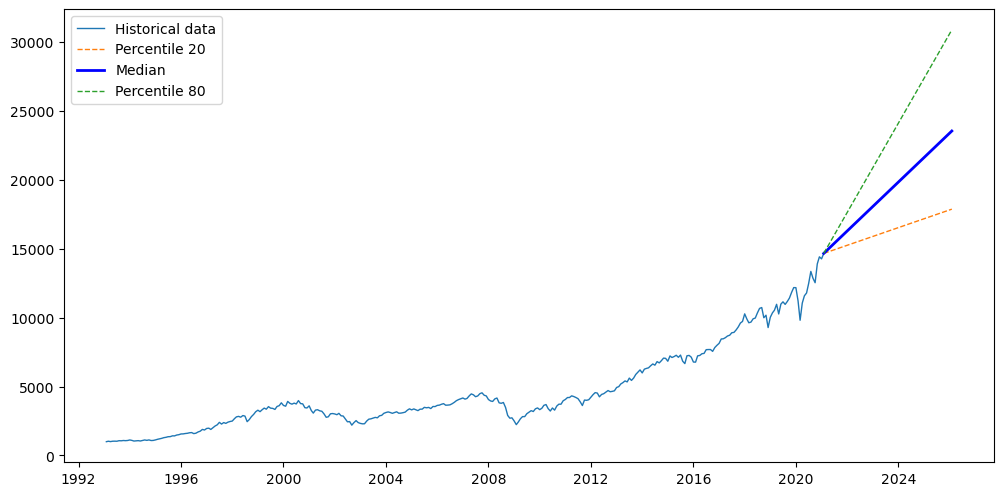

In [26]:
ht.plot_forecast(years=5, percentiles=[20, 50, 80]);

In [27]:
ht.forecast_wealth(distr='hist', years=5)

{10: 13610.540513854748, 50: 23687.7775959962, 90: 38925.27291977133}

Quantitative CAGR percentiles could be obtained from **percentile_from_history** method:

In [28]:
ht.percentile_from_history(years=5)

,10,50,90
years,,,
1,-0.128587,0.132951,0.296834
2,-0.103500,0.118844,0.260482
3,-0.070621,0.116964,0.249786
4,-0.042717,0.120532,0.229334
5,-0.014756,0.100711,0.215668


We can visualize the same to see how CAGR ranges were narrowing with investment horizon.

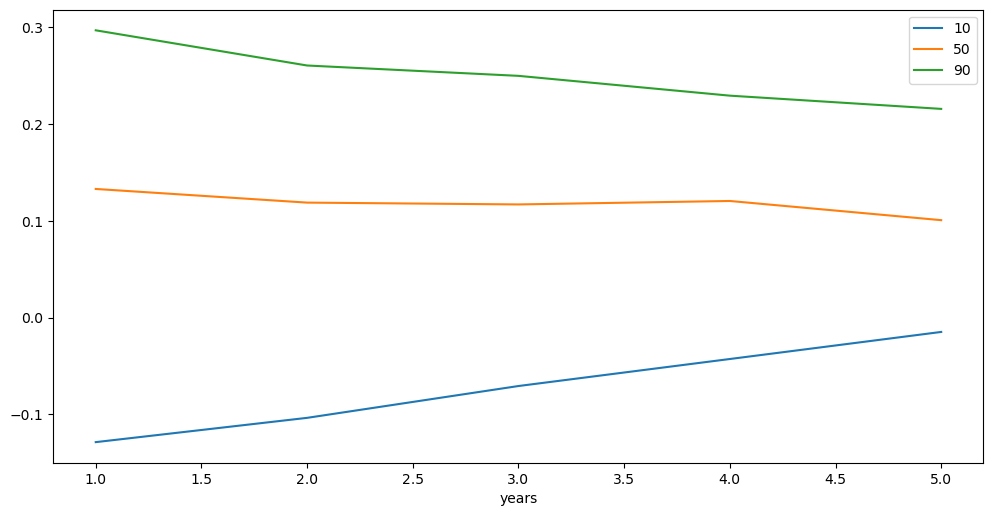

In [29]:
ht.percentile_from_history(years=5).plot();